# 📈 Evaluación Exhaustiva del Modelo (Model Evaluation)

## 🎯 Objetivo
Este notebook tiene como objetivo evaluar el rendimiento del modelo final (`best_pipeline.pkl`) en un conjunto de datos de prueba (o validación). 
Nos centraremos en métricas críticas para el diagnóstico médico, como el **Recall** (Sensibilidad) y el **F2-Score**, además de la interpretabilidad del modelo.

## 📋 Pasos
1.  **Carga de Artefactos**: Modelo, datos y configuración de umbral.
2.  **Predicción**: Generación de probabilidades y etiquetas.
3.  **Evaluación de Desempeño**: Matriz de Confusión, ROC, PR Curve.
4.  **Interpretabilidad**: Feature Importance y SHAP.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import load_model, predict_model
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             auc, fbeta_score)
import shap
import json
import os

# Configuración de Estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Rutas
MODEL_PATH = "../models/best_pipeline"
DATA_PATH = "../data/02_intermediate/process_data.parquet"
THRESHOLD_CONFIG_PATH = "../models/threshold_config.json"
CONFIG_PATH = "../models/model_config.json"

In [2]:
def get_base_estimator(model):
    # Unwrap CalibratedClassifierCV
    if hasattr(model, 'calibrated_classifiers_'):
        # It's a CalibratedClassifierCV
        # Get the first calibrated classifier
        calibrated_classifier = model.calibrated_classifiers_[0]
        # Now unwrap the internal _CalibratedClassifier
        if hasattr(calibrated_classifier, 'estimator'):
            return calibrated_classifier.estimator
        elif hasattr(calibrated_classifier, 'base_estimator'):
            return calibrated_classifier.base_estimator
        else:
            # Fallback, maybe it is the model itself?
            return calibrated_classifier
    
    # Unwrap simple wrapper (if any)
    if hasattr(model, 'estimator'):
        return model.estimator
    if hasattr(model, 'base_estimator'):
        return model.base_estimator
        
    return model

## 1. Carga de Datos y Modelo

In [3]:
# Cargar Modelo
try:
    pipeline = load_model(MODEL_PATH)
    print("✅ Modelo cargado exitosamente.")
except Exception as e:
    print(f"❌ Error al cargar el modelo: {e}")

# Cargar Datos
try:
    df = pd.read_parquet(DATA_PATH)
    # Usar una muestra para evaluación rápida si es necesario, o el set completo
    # Aquí usamos el 20% como set de 'prueba' simulado si no tenemos uno separado explícito
    df_eval = df.sample(frac=0.2, random_state=123)
    print(f"✅ Datos cargados. Shape evaluación: {df_eval.shape}")
except Exception as e:
    print(f"❌ Error al cargar datos: {e}")

# Cargar Configuración de Umbral
OPTIMAL_THRESHOLD = 0.5
if os.path.exists(THRESHOLD_CONFIG_PATH):
    with open(THRESHOLD_CONFIG_PATH, 'r') as f:
        thresh_config = json.load(f)
        OPTIMAL_THRESHOLD = thresh_config.get('optimal_threshold', 0.5)
    print(f"✅ Umbral óptimo cargado: {OPTIMAL_THRESHOLD:.4f}")
else:
    print("⚠️ No se encontró threshold_config.json. Usando umbral por defecto 0.5.")
    print("   (Ejecuta el notebook 02 para generar el umbral óptimo)")

Transformation Pipeline and Model Successfully Loaded
✅ Modelo cargado exitosamente.
✅ Datos cargados. Shape evaluación: (8739, 29)
✅ Umbral óptimo cargado: 0.0000


## 2. Generación de Predicciones

In [4]:
# Generar predicciones (probabilidades crudas)
predictions = predict_model(pipeline, data=df_eval, raw_score=True)

# Identificar columna de probabilidad de clase positiva (1)
# PyCaret suele generar 'prediction_score_1' o 'prediction_score' (si es binario)
score_col = 'prediction_score_1' if 'prediction_score_1' in predictions.columns else 'prediction_score'

# Si solo hay 'prediction_score', a veces es la prob de la clase predicha.
# Ajustamos para obtener siempre la prob de clase 1.
if score_col == 'prediction_score':
    # Si prediction_label es 1, score es prob(1). Si es 0, score es prob(0) -> prob(1) = 1 - score
    y_prob = predictions.apply(lambda x: x['prediction_score'] if x['prediction_label'] == 1 else 1 - x['prediction_score'], axis=1)
else:
    y_prob = predictions[score_col]

# Obtener etiquetas reales
with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)
target_col = config['target']
y_true = predictions[target_col]

# Aplicar Umbral Óptimo
y_pred_custom = (y_prob >= OPTIMAL_THRESHOLD).astype(int)

print("Predicciones generadas con umbral personalizado.")

Predicciones generadas con umbral personalizado.


## 3. Evaluación de Desempeño

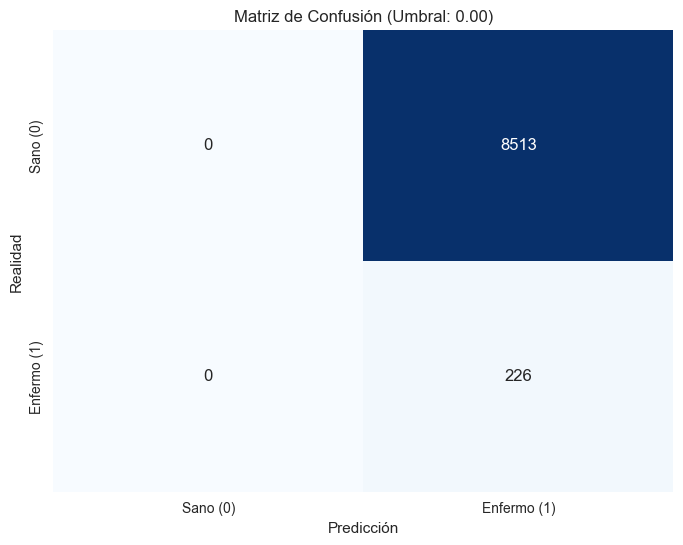


📊 Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      8513
         1.0       0.03      1.00      0.05       226

    accuracy                           0.03      8739
   macro avg       0.01      0.50      0.03      8739
weighted avg       0.00      0.03      0.00      8739

⭐ F2-Score: 0.1172
⭐ ROC AUC:  0.9030


In [5]:
# Matriz de Confusión
cm = confusion_matrix(y_true, y_pred_custom)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sano (0)', 'Enfermo (1)'],
            yticklabels=['Sano (0)', 'Enfermo (1)'])
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title(f'Matriz de Confusión (Umbral: {OPTIMAL_THRESHOLD:.2f})')
plt.show()

# Reporte de Clasificación
print("\n📊 Reporte de Clasificación:")
print(classification_report(y_true, y_pred_custom))

# Métricas Adicionales
f2 = fbeta_score(y_true, y_pred_custom, beta=2)
roc_auc = roc_auc_score(y_true, y_prob)
print(f"⭐ F2-Score: {f2:.4f}")
print(f"⭐ ROC AUC:  {roc_auc:.4f}")

### 3.1 Curvas ROC y Precision-Recall

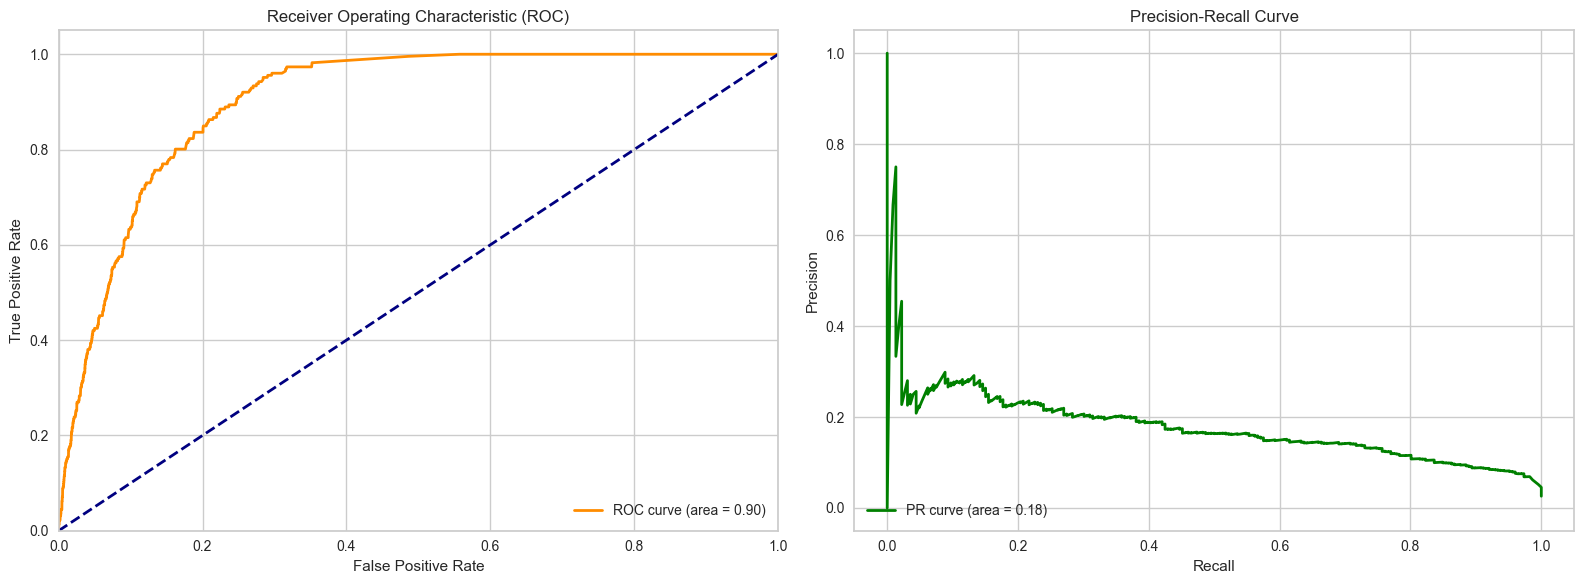

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)
ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")

plt.tight_layout()
plt.show()

### 4.1 Importancia de Variables (Feature Importance)
Visualizamos las variables más influyentes según el modelo.

In [7]:
# Intentar usar plot_model de PyCaret
try:
    print("Generando gráfico de importancia de variables...")
    # plot_model a veces falla con pipelines complejos o wrappers, así que envolvemos en try
    # plot='feature' muestra la importancia de características
    # save=True guardaría la imagen, pero aquí queremos mostrarla
    # display_format='streamlit' a veces ayuda en ciertos entornos, pero por defecto está bien
    
    # Nota: plot_model usa el modelo final del pipeline. 
    # Si es un CalibratedClassifierCV, PyCaret suele manejarlo, pero si falla, usamos extracción manual.
    from pycaret.classification import plot_model
    # plot_model requiere setup() activo, lo cual no tenemos aquí.
    # Así que saltamos directo a la extracción manual si no hay experimento activo.
    raise Exception("Skipping plot_model because setup() is not active.")
    # plot_model(pipeline, plot='feature', scale=1.0, save=False)
    
except Exception as e:
    print(f"⚠️ PyCaret plot_model saltado/falló: {e}")
    print("Intentando extracción manual de importancias...")
    
    try:
        # Extracción manual como fallback
        model_step = pipeline.steps[-1][1]
        
        # Usar la función robusta
        final_estimator = get_base_estimator(model_step)
        
        if hasattr(final_estimator, 'feature_importances_'):
            importances = final_estimator.feature_importances_
            
            # Intentar obtener nombres de features
            try:
                preprocessor = pipeline[:-1]
                # Transformar una muestra para ver las columnas de salida
                X_sample = df_eval.drop(columns=[target_col]).head()
                X_trans = preprocessor.transform(X_sample)
                if hasattr(X_trans, 'columns'):
                    feat_names = X_trans.columns
                else:
                    # Si devuelve numpy array (común en sklearn pipelines puros)
                    feat_names = [f"Feature {i}" for i in range(len(importances))]
            except:
                feat_names = [f"Feature {i}" for i in range(len(importances))]
            
            # Crear DataFrame y plotear
            fi_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
            fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
            plt.title('Top 15 Feature Importances (Manual Extraction)')
            plt.show()
        else:
            print(f"❌ El modelo {type(final_estimator)} no tiene atributo 'feature_importances_'.")
            
    except Exception as e2:
        print(f"❌ Falló también la extracción manual: {e2}")

Generando gráfico de importancia de variables...
⚠️ PyCaret plot_model saltado/falló: Skipping plot_model because setup() is not active.
Intentando extracción manual de importancias...
❌ Falló también la extracción manual: All arrays must be of the same length


## 4. Interpretabilidad (SHAP)
Analizamos cómo cada variable impacta en la predicción.

In [8]:
try:
    # Extraer el modelo subyacente del pipeline
    model_step = pipeline.steps[-1][1]
    
    # Usar la función robusta para obtener el estimador base
    print("Extrayendo estimador base para SHAP...")
    final_estimator = get_base_estimator(model_step)
    print(f"Estimador para SHAP: {type(final_estimator)}")

    # Preparar datos para SHAP (transformados)
    # Necesitamos pasar los datos por el pipeline de preprocesamiento
    preprocessor = pipeline[:-1]
    X_sample = df_eval.drop(columns=[target_col]).sample(100, random_state=42) # Muestra pequeña para velocidad
    X_transformed = preprocessor.transform(X_sample)
    
    # Crear Explainer
    # TreeExplainer es rápido para árboles (XGBoost, RF, etc.)
    explainer = shap.TreeExplainer(final_estimator)
    shap_values = explainer.shap_values(X_transformed)
    
    plt.figure()
    plt.title("SHAP Summary Plot")
    shap.summary_plot(shap_values, X_transformed, show=True)
    
except Exception as e:
    print(f"⚠️ No se pudo generar el gráfico SHAP: {e}")
    print("Esto puede ocurrir si el modelo no es basado en árboles o si la estructura del pipeline es compleja.")

Extrayendo estimador base para SHAP...
Estimador para SHAP: <class 'xgboost.sklearn.XGBClassifier'>
⚠️ No se pudo generar el gráfico SHAP: [14:13:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\c_api\c_api_utils.h:129: Check failed: std::accumulate(shape.cbegin(), shape.cend(), static_cast<bst_ulong>(1), std::multiplies<>{}) == chunksize * rows (3200 vs. 3100) : 
Esto puede ocurrir si el modelo no es basado en árboles o si la estructura del pipeline es compleja.
